# Steady-state simulation examples

**Note:** These examples use the simple-to-use SteadyStateSimulation interface which lacks some of the functionality of the more advanced DynamicSimulation interface. If you need to model time-varying signals, reflective boundary conditions (for example a laser cavity) and/or radially varying doping concentration or excitation, use the more advanced DynamicSimulation interface.

### Imports

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Example 1: 17 dB double-clad Yb-doped fiber amplifier

This example reproduces some of the results in [1], whose authors used the commercial RP Fiber Power software to model a double-clad fiber amplifier. The initial parameters should define an amplifier with 17 dB gain. 

In [2]:
from pyfiberamp.steady_state import SteadyStateSimulation
from pyfiberamp.fibers import YbDopedDoubleCladFiber
from pyfiberamp.mode_solver import GaussianMode

In [3]:
# The fiber parameters
length = 3
core_radius = 5e-6
pump_cladding_radius = 50e-6
ratio_of_core_and_cladding_diameters = core_radius / pump_cladding_radius
core_na = 0.12 # This does not play a role since we define the mode field diameter later
yb_number_density = 3e25
background_loss = 0

In [4]:
# Create the fiber
dc_fiber = YbDopedDoubleCladFiber(length=length,
                               core_radius=core_radius,
                               core_na=core_na,
                               ratio_of_core_and_cladding_diameters=ratio_of_core_and_cladding_diameters,
                               ion_number_density=yb_number_density,
                               background_loss=background_loss)
#dc_fiber.default_signal_mode_shape_parameters['functional_form'] = 'gaussian'

In [5]:
# Create the simulation and add signal and pump channels
simulation = SteadyStateSimulation(fiber=dc_fiber)
simulation.add_forward_signal(wl=1030e-9, input_power=0.4, mode=GaussianMode(mfd=9.6e-6, core_radius=dc_fiber.core_radius))
simulation.add_backward_pump(wl=914e-9, input_power=47.2)

In [6]:
# Run the simulation
result = simulation.run(tol=1e-4)

   Iteration    Max residual    Total nodes    Nodes added  
       1          8.30e-04          20              3       
       2          9.99e-05          23              0       
Solved in 2 iterations, number of nodes 23, maximum relative residual 9.99e-05.


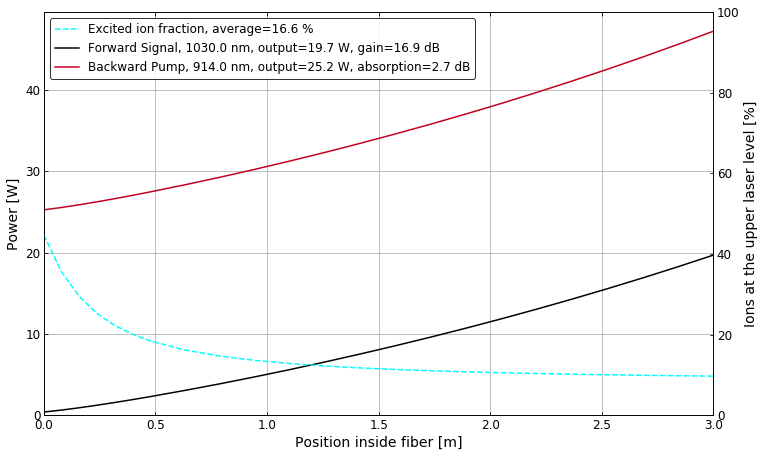

In [7]:
# Plotting the steady state
result.plot_power_evolution()

The authors of ref [1] obtained a signal gain of 17 dB in their simulation. The 16.9 dB gain predicted by PyFiberAmp is very close and the difference can be explained by the fact that the absorption and emission cross sections used in the simulations must be slightly different.

## Example 2: Raman generation in passive fiber

This example demonstrates stimulated Raman scattering in a long passive optical fiber at 1550 nm. The numbers are taken from Agrawal's Nonlinear Fiber Optics (4th edition) pages 278-279 [2]. The approximate formula for Raman threshold predicts that signal and Raman powers should be equal at the fiber output with the given initial parameters.

In [8]:
from pyfiberamp.fibers import PassiveFiber
from pyfiberamp.steady_state import SteadyStateSimulationWithRaman
from pyfiberamp.helper_funcs import decibel_to_exp

In [9]:
# The fiber parameters as in Agrawal's book
length = 20e3
effective_area = 50e-12
core_radius = np.sqrt(effective_area / np.pi)
background_loss_dB = 0.0002
core_na = 0.12 # does not play a role here but some value is required

In [10]:
# Create the fiber
raman_fiber = PassiveFiber(length=length,
                           core_radius=core_radius,
                           core_na=core_na,
                           background_loss = decibel_to_exp(background_loss_dB))
raman_fiber.effective_area_type = 'core' # This makes sure that we are using the correct effective area 50 um^2

In [11]:
# Create the simulation and optical channels
raman_simulation = SteadyStateSimulationWithRaman(fiber=raman_fiber)
raman_simulation.add_forward_signal(wl=1550e-9, input_power=0.6)
raman_simulation.add_raman(backward_raman_allowed=False)

In [12]:
# Run the simulation. Raman simulation typically requires a tighter tolerance to obtain the correct result.
# With tol=1e-5, the Raman output power would be just 0.087 W
raman_result = raman_simulation.run(tol=1e-6)

   Iteration    Max residual    Total nodes    Nodes added  
       1          1.21e-03          20             10       
       2          1.33e-05          30              4       
       3          5.51e-09          34              0       
Solved in 3 iterations, number of nodes 34, maximum relative residual 5.51e-09.


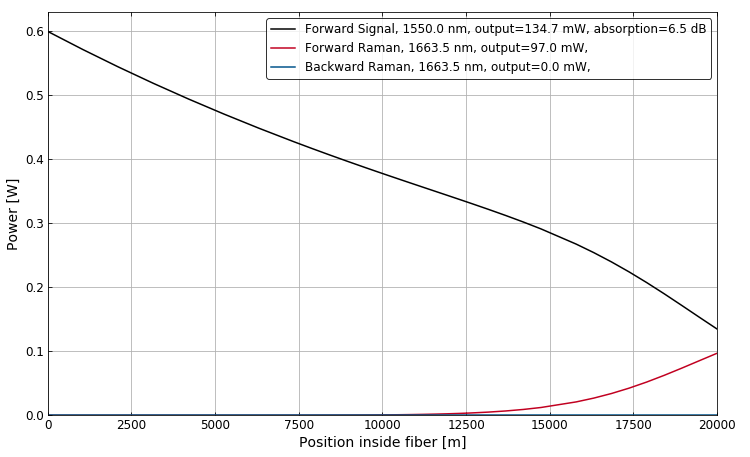

In [13]:
#Plotting the steady state power evolution
raman_result.plot_power_evolution()

The signal and Raman powers are almost equal, so the agreement with the approximation formula for Raman threshold is good.

## Example 3: Parameter sweep

This example uses the same design as example 1. This time we vary the pump wavelength and record how the signal gain changes with pump wavelength.

In [14]:
# Parameters
pump_wavelengths = np.linspace(890, 1030, 101) * 1e-9
simulated_gains = []
result = None

In [15]:
# Function to calculate the gain at a single pump wavelength
def run_single_simulation(pump_wavelength, result):
    # The simulation has to be initialized again even though only one parameter changes
    simulation = SteadyStateSimulation(dc_fiber)
    simulation.solver_verbosity = 0
    simulation.add_forward_signal(wl=1030e-9,
                                  input_power=0.4,
                                  mode=GaussianMode(mfd=2*4.8e-6, core_radius=dc_fiber.core_radius),
                                 channel_id='signal')
    simulation.add_backward_pump(wl=pump_wl, input_power=47.2)
    
    # Starting from the 2nd simulation, we can use the previous result as
    # the initial guess for the next simulation to speed up the calculation.
    if result is not None:
        simulation.set_guess_array(result.powers)
    
    # The simulation is run and the gain is stored in a list
    return simulation.run(tol=1e-5)

In [16]:
# Looping over the pump wavelengths
for pump_wl in pump_wavelengths:
    result = run_single_simulation(pump_wl, result)
    result_dict = result.make_result_dict()
    gain = result_dict['signal']['gain']
    simulated_gains.append(gain)

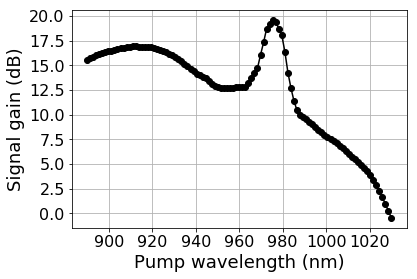

In [17]:
# Plotting the gain vs. pump wavelength
plt.plot(pump_wavelengths * 1e9, simulated_gains, 'ko-')
plt.xlabel('Pump wavelength (nm)', fontsize=18)
plt.ylabel('Signal gain (dB)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.show()

The result looks realistic, showing a broad peak around 915 nm and a sharper peak at 976 nm. As the pump wavelength approaches the signal wavelength 1030 nm, the gain goes to zero. The small "jumps" are caused by the roughness of the cross section data.

If you have want to ask a question of send feedback about these examples, please open a new issue on GitHub or contact me at <pyfiberamp@gmail.com>.

## References

[1] Albalawi, A., Zhu, H., Taccheo, S. et al. Opt Quant Electron (2016) 48: 500. https://doi.org/10.1007/s11082-016-0771-z

[2] Govind P. Agrawal, Chapter 8 - Stimulated Raman Scattering, In Optics and Photonics, Academic Press, San Diego, 2006, Pages 278-279, ISSN 15575837, Nonlinear Fiber Optics (Fourth Edition), ISBN 9780123695161